In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [4]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [5]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Building autoencoder

In [6]:
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K


In [7]:
def create_encoder(input_shape,code_size, use_dropout=True):
        encoder = tf.keras.models.Sequential(name='encoder')
        encoder.add(L.InputLayer(input_shape))
        if use_dropout:
            encoder.add(L.Dropout(0.3))
        encoder.add(L.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Flatten())
        encoder.add(L.Dense(units=code_size,activation='elu'))
        return encoder 
    
def create_decoder(code_size):
        decoder = tf.keras.models.Sequential(name='decoder')
        decoder.add(L.InputLayer((code_size,)))
        decoder.add(L.Dense(3*3*512,activation='elu'))
        decoder.add(L.Reshape(target_shape=(3,3,512)))
        decoder.add(L.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, activation='elu', padding='valid'))
        decoder.add(L.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
        return decoder
    
def build_model(input_shape,code_size, use_dropout=True,
               print_summary=True,encoder_weights=None,
               decoder_weights=None):
    K.clear_session()
    encoder = create_encoder(input_shape,code_size,use_dropout)
    if encoder_weights:
        encoder.load_weights(encoder_weights)
    decoder = create_decoder(code_size)
    if decoder_weights:
        decoder.load_weights(decoder_weights)
    inp = L.Input(original_dim)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
    autoencoder.compile(optimizer="adamax", loss='mse')
    if print_summary:
        print(autoencoder.summary())
    return autoencoder,encoder,decoder

In [8]:
batch_size = 128
original_dim = (224,224,3)
code_size = 128
epochs = 10
use_dropout=False

In [9]:
autoencoder, encoder, decoder = build_model(original_dim, code_size, use_dropout)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 128)               4779968   
_________________________________________________________________
decoder (Sequential)         (None, 224, 224, 3)       4522307   
Total params: 9,302,275
Trainable params: 9,302,275
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2951

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4608)              594432    
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 512)         2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 64)        73792     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 112, 112, 32)      1846

# Training

In [12]:
images.shape

(3840, 224, 224, 3)

In [13]:
history = autoencoder.fit(x=images,y=images, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=False)

Train on 3456 samples, validate on 384 samples
Epoch 1/10
3456/3456 [==============================] - 32s 9ms/sample - loss: 0.1384 - val_loss: 0.0790
Epoch 2/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0708 - val_loss: 0.0554
Epoch 3/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0536 - val_loss: 0.0449
Epoch 4/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0455 - val_loss: 0.0382
Epoch 5/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0400 - val_loss: 0.0386
Epoch 6/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0375 - val_loss: 0.0326
Epoch 7/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0346 - val_loss: 0.0311
Epoch 8/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0329 - val_loss: 0.0293
Epoch 9/10
3456/3456 [==============================] - 24s 7ms/sample - loss: 0.0317 - val_loss: 0.0283
Epoch 10

# Validating features

In [14]:
model = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[-4].output)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0   

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

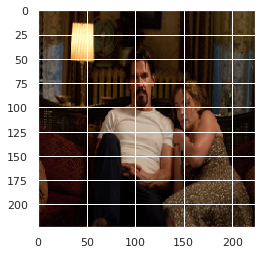

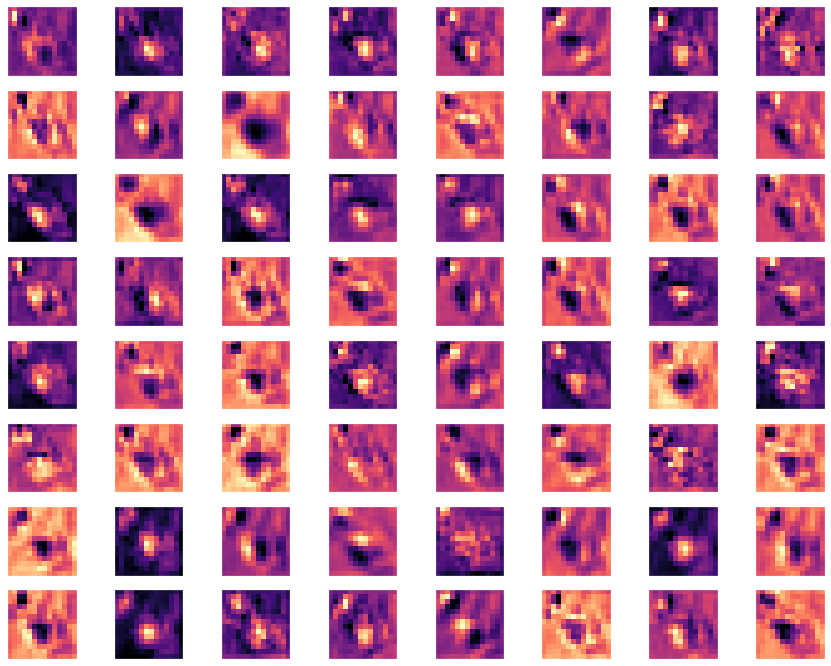

In [16]:
img = images[np.random.choice(images.shape[0])]
plt.imshow(img)
feature_maps = model.predict(np.expand_dims(img,axis=0))
square = 8
ix = 1
plt.figure(figsize=(15,12))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
        ix += 1
plt.show()

# Saving model

In [17]:
encoder.save('encoder.h5')